<h2 style="color: deepskyblue;">MODELOS DE REGRESIÓN</h2>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

## Preprocesamiento de datos

In [ ]:

df = pd.read_csv('diabetes.csv')

X = df.drop('BMI', axis=1)  
y = df['BMI']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.98, random_state=42)


numeric_features = [ 'MentHlth', 'PhysHlth', 'Age']  
binary_features = ['HighBP', 'HighChol','CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity',
                   'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
                   'DiffWalk','Sex']
ordinal_features = ['GenHlth','Education','Income']


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('ord', 'passthrough', ordinal_features),
        ('bin', 'passthrough', binary_features)
    ])

# Aplicar preprocesamiento
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

## Funciones generales

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# Función para entrenar y evaluar el modelo con Pipeline y GridSearchCV
def entrenar_evaluar_modelo_con_pipeline_regresion(modelo_base, param_grid, X_train, y_train, X_test, y_test, preprocessor):
    """
    Entrena y evalúa un modelo con Pipeline y GridSearchCV para regresión.
    Devuelve un diccionario con las métricas clave para comparar modelos.
    """
    # Crear pipeline con preprocesador y modelo
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('regresor', modelo_base)
    ])

    # Configurar GridSearchCV
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Entrenar modelo
    start_time = time.time()
    grid.fit(X_train, y_train)
    end_time = time.time()

    # Predicción con el mejor modelo
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calcular las métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Calcular ACF de los residuos y p-value de Ljung-Box
    residuos = y_test - y_pred
    ljung_box_pvalue = acorr_ljungbox(residuos, lags=[10], return_df=True)['lb_pvalue'].values[0]

    # Test Jarque-Bera
    jb_stat, jb_pvalue = stats.jarque_bera(residuos)

    # Crear un diccionario con los resultados clave
    resultados = {
        'Modelo': tipo_modelo(modelo_base),
        'Mejores Hiperparámetros': grid.best_params_,
        'Tiempo de Entrenamiento (s)': end_time - start_time,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2,
        'Ljung-Box p-value': ljung_box_pvalue,
        'Jarque-Bera p-value': jb_pvalue
    }

    # Graficar la relación entre las predicciones y la variable objetivo
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.6, color='darkorange')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='k', linestyle='--')
    plt.xlabel('Valor Real')
    plt.ylabel('Valor Predicho')
    plt.title('Real vs Predicho')
    plt.tight_layout()
    plt.show()

    # Graficar el histograma de los residuos
    plt.figure(figsize=(6, 4))
    plt.hist(residuos, bins=20, color='dodgerblue', alpha=0.7)
    plt.title('Histograma de Residuos')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

    return resultados

# Función para obtener el tipo de modelo (Nombre)
def tipo_modelo(modelo):
    if isinstance(modelo, KNeighborsRegressor):
        return "KNN"
    elif isinstance(modelo, LinearRegression):
        return "Regresión Lineal"
    elif isinstance(modelo, Ridge):
        return "Ridge"
    elif isinstance(modelo, Lasso):
        return "Lasso"
    elif isinstance(modelo, RandomForestRegressor):
        return "RandomForestRegressor"
    elif isinstance(modelo, XGBRegressor):
        return "XGBoost Regressor"
    elif isinstance (modelo, SVR):
        return "SVR"
    elif isinstance(modelo, StackingRegressor):
        return "Stacking"
    else:
        return "Otro Modelo"

# Función para comparar los resultados de múltiples modelos
def Comparar_modelos(resultados_modelos):
    """
    Compara múltiples modelos y devuelve un DataFrame con sus métricas.
    """
    return pd.DataFrame(resultados_modelos)

## K-Nearest Neighbors (KNN)

In [ ]:

from sklearn.neighbors import KNeighborsRegressor

# Definir el modelo 
modelo_knn = KNeighborsRegressor()

# Definir el espacio de búsqueda de hiperparámetros 
param_grid_knn = {
    'regresor__n_neighbors': [3, 5, 7],  # Número de vecinos
    'regresor__weights': ['uniform', 'distance'],  # Tipo de peso
    'regresor__p': [1, 2]  # 1 = Manhattan, 2 = Euclidiana
}

# Entrenar y evaluar
Resultados_knn = entrenar_evaluar_modelo_con_pipeline_regresion(
    modelo_knn, 
    param_grid_knn, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    preprocessor
)

# Mostrar los resultados 
print("\nResultados del modelo KNN:")
print(Resultados_knn)


## Regresión lineal

In [ ]:
# Importar el regresor 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Definir el modelo 
modelo_regresion = LinearRegression()

# Definir el espacio de búsqueda de hiperparámetros 
param_grid_regresion = {
    'regresor__fit_intercept': [True, False],  # Incluir el término independiente o no
}

# Entrenar y evaluar el modelo de 
Resultados_regresion = entrenar_evaluar_modelo_con_pipeline_regresion(
    modelo_regresion, 
    param_grid_regresion, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    preprocessor
)

# Mostrar los resultados 
print("\nResultados del modelo de regresión lineal:")
print(Resultados_regresion)



## Ridge

In [ ]:
# Importar el regresor 
from sklearn.linear_model import Ridge

# Definir el modelo 
modelo_ridge = Ridge()

# Definir el espacio de búsqueda de hiperparámetros 
param_grid_ridge = {
    'regresor__alpha': [0.1, 1, 10, 100],  # Parámetro de regularización
    'regresor__fit_intercept': [True, False],  # Incluir el término independiente o no
}

# Entrenar y evaluar 
Resultados_ridge = entrenar_evaluar_modelo_con_pipeline_regresion(
    modelo_ridge, 
    param_grid_ridge, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    preprocessor
)

# Mostrar los resultados 
print("\nResultados del modelo Ridge:")
print(Resultados_ridge)


## Lasso

In [ ]:
# Importar el regresor Lasso
from sklearn.linear_model import Lasso

# Definir el modelo Lasso
modelo_lasso = Lasso()

# Definir el espacio de búsqueda de hiperparámetros para Lasso
param_grid_lasso = {
    'regresor__alpha': [0.1, 1, 10, 100],  # Parámetro de regularización
    'regresor__fit_intercept': [True, False],  # Incluir el término independiente o no
}

# Entrenar y evaluar el modelo Lasso
Resultados_lasso = entrenar_evaluar_modelo_con_pipeline_regresion(
    modelo_lasso, 
    param_grid_lasso, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    preprocessor
)

# Mostrar los resultados del modelo Lasso
print("\nResultados del modelo Lasso:")
print(Resultados_lasso)

## Random Forest

In [ ]:
# Importar el regresor 
from sklearn.ensemble import RandomForestRegressor

# Definir el modelo
modelo_rf = RandomForestRegressor(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid_rf = {
    'regresor__n_estimators': [50, 100, 200],  # Número de árboles
    'regresor__max_features': ['auto', 'sqrt', 'log2'],  # Número de características a considerar para cada división
    'regresor__max_depth': [None, 10, 20, 30],  # Profundidad máxima del árbol
    'regresor__min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'regresor__min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en cada hoja
}

# Entrenar y evaluar el modelo Random Forest
Resultados_rf = entrenar_evaluar_modelo_con_pipeline_regresion(
    modelo_rf, 
    param_grid_rf, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    preprocessor
)

# Mostrar los resultados 
print("\nResultados del modelo Random Forest:")
print(Resultados_rf)

## XGBoost

In [ ]:
# Importar el regresor
from xgboost import XGBRegressor

# Definir el modelo 
modelo_xgb = XGBRegressor(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros 
param_grid_xgb = {
    'regresor__n_estimators': [50, 100, 200],  # Número de árboles
    'regresor__learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'regresor__max_depth': [3, 5, 7],  # Profundidad máxima de los árboles
    'regresor__subsample': [0.8, 0.9, 1.0],  # Proporción de muestras para entrenar cada árbol
    'regresor__colsample_bytree': [0.8, 0.9, 1.0],  # Proporción de características a considerar por árbol
    'regresor__alpha': [0, 0.1, 1],  # Regularización L1
    'regresor__lambda': [0, 1, 10],  # Regularización L2
}

# Entrenar y evaluar 
Resultados_xgb = entrenar_evaluar_modelo_con_pipeline_regresion(
    modelo_xgb, 
    param_grid_xgb, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    preprocessor
)

# Mostrar los resultados del modelo XGBoost
print("\nResultados del modelo XGBoost:")
print(Resultados_xgb)

## Support Vector Regression

In [ ]:
# Importar el regresor
from sklearn.svm import SVR

# Definir el modelo base
modelo_svr = SVR()

# Definir el espacio de búsqueda de hiperparámetros
param_grid_svr = {
    'regresor__kernel': ['linear', 'rbf', 'poly'],   # Tipos de núcleo
    'regresor__C': [0.1, 1, 10],                     # Penalización por error (regularización)
    'regresor__epsilon': [0.01, 0.1, 1],             # Margen de tolerancia en el error
    'regresor__gamma': ['scale', 'auto']            # Parámetro del kernel (afecta rbf y poly)
}

# Entrenar y evaluar el modelo SVR
Resultados_svr = entrenar_evaluar_modelo_con_pipeline_regresion(
    modelo_svr,
    param_grid_svr,
    X_train,
    y_train,
    X_test,
    y_test,
    preprocessor
)

# Mostrar los resultados del modelo SVR
print("\nResultados del modelo Support Vector Regression:")
print(Resultados_svr)

## Meta modelo Regression

In [ ]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.svm import SVR

# 📌 Definir los estimadores base
estimators = [
    ('xgb', XGBRegressor(n_estimators=100, max_depth=3, random_state=42, verbosity=0)),
    ('svr', SVR(C=1.0, epsilon=0.2)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]

# 📌 Definir el stacking regressor
modelo_stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)

# 📌 Definir espacio de búsqueda de hiperparámetros
param_grid_stacking = {
    'regresor__final_estimator__alpha': [1.0, 5.0, 10.0],
    'regresor__xgb__max_depth': [3, 5],
    'regresor__rf__max_depth': [10, 20],
    'regresor__rf__n_estimators': [100, 200]
}

# 📌 Entrenar y evaluar
Resultados_stacking = entrenar_evaluar_modelo_con_pipeline_regresion(
    modelo_stacking,
    param_grid_stacking,
    X_train,
    y_train,
    X_test,
    y_test,
    preprocessor
)

# 📌 Mostrar resultados
print("\nResultados del modelo Stacking:")
print(Resultados_stacking)

## Comparación

In [ ]:
# Almacenar los resultados en una lista
Resultados_comparacion = [Resultados_knn, Resultados_regresion, Resultados_ridge,  Resultados_lasso, 
                          Resultados_svr, Resultados_xgb,Resultados_rf,Resultados_stacking]

# Comparar modelos
Df_comparacion = Comparar_modelos(Resultados_comparacion)

# Mostrar tabla comparativa
print(Df_comparacion)

In [ ]:

mejor_RMSE = Df_comparacion.loc[Df_comparacion['RMSE'].idxmax()]


print("Modelo con mejor RMSE:")
print(mejor_RMSE)

<h1 style="color: deepPINK;">MODELOS DE SEGMENTACIÓN</h1>

## Preprocesamiento de datos

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Cargar los datos
df = pd.read_csv('diabetes.csv')

# Seleccionar una muestra aleatoria de 23,000 observaciones
df_sample = df.sample(n=23000, random_state=42)

# Definir columnas
numeric_features = ['BMI', 'MentHlth', 'PhysHlth', 'Age']  # Variables numéricas
binary_features = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
                   'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 
                   'NoDocbcCost', 'DiffWalk', 'Sex']  # Variables binarias
ordinal_features = ['GenHlth', 'Education', 'Income']  # Variables ordinales

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('ord', 'passthrough', ordinal_features),
        ('bin', 'passthrough', binary_features)
    ]
)

# Preprocesar todo el dataset (incluyendo la variable objetivo para evaluación posterior)
X_sample = df_sample.drop(columns=[])  
X_sample_prep = preprocessor.fit_transform(X_sample.drop(columns=['Diabetes_binary']))

# Guardamos aparte la variable para evaluar agrupamientos 
y_sample = df_sample['Diabetes_binary']


## Funciones generales

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

def entrenar_evaluar_segmentacion(modelo_base, param_grid, X, preprocessor):
    """
    Entrena y evalúa un modelo de segmentación usando Pipeline y GridSearchCV.
    Devuelve un diccionario con las métricas de evaluación y etiquetas.
    """
    from sklearn.decomposition import PCA
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import time

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('segmentador', modelo_base)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=silhouette_scorer,
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    start_time = time.time()
    grid.fit(X)
    end_time = time.time()

    best_model = grid.best_estimator_
    etiquetas = best_model.named_steps['segmentador'].labels_

    silhouette = silhouette_score(X, etiquetas)
    db_index = davies_bouldin_score(X, etiquetas)
    ch_score = calinski_harabasz_score(X, etiquetas)

    resultados = {
        'Modelo': tipo_modelo_segmentacion(modelo_base),
        'Mejores Hiperparámetros': grid.best_params_,
        'Tiempo de Entrenamiento (s)': round(end_time - start_time, 2),
        'Silhouette Score': round(silhouette, 4),
        'Davies-Bouldin Score': round(db_index, 4),
        'Calinski-Harabasz Score': round(ch_score, 4),
        'etiquetas': etiquetas  # ✅ Se añaden las etiquetas al diccionario
    }

    # Visualización
    try:
        X_reducido = PCA(n_components=2).fit_transform(X)
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=X_reducido[:, 0], y=X_reducido[:, 1], hue=etiquetas, palette='tab10', s=40)
        plt.title("Visualización de Clusters")
        plt.xlabel("Componente Principal 1")
        plt.ylabel("Componente Principal 2")
        plt.legend(title="Cluster")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except:
        print("No fue posible realizar la visualización PCA")

    return resultados

# Scorer personalizado
def silhouette_scorer(estimator, X):
    try:
        labels = estimator.fit_predict(X)
        if len(set(labels)) > 1:
            return silhouette_score(X, labels)
        else:
            return -1
    except:
        return -1

# Identificación de modelo
def tipo_modelo_segmentacion(modelo):
    from sklearn.cluster import KMeans, DBSCAN, Birch
    if isinstance(modelo, KMeans):
        return "KMeans"
    elif isinstance(modelo, DBSCAN):
        return "DBSCAN"
    elif isinstance(modelo, Birch):
        return "BIRCH"
    else:
        return "Otro Segmentador"

# Comparador entre modelos
def comparar_segmentadores(resultados_segmentadores):
    return pd.DataFrame(resultados_segmentadores)

## K-Means

/opt/miniconda3/envs/ml_venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


📈 Evaluación interna del modelo KMeans:
Silhouette Score: 0.31279941415668344
Davies-Bouldin Score: 1.4274958363776489
Calinski-Harabasz Score: 9910.74604274296

📊 Evaluación externa con respecto a 'Diabetes_binary':
ARI (Adjusted Rand Index): 0.08289790390353076
NMI (Normalized Mutual Information): 0.03142078036870896
Homogeneity: 0.040263116469098054
Completeness: 0.025762893392441272
V-Measure: 0.03142078036870896


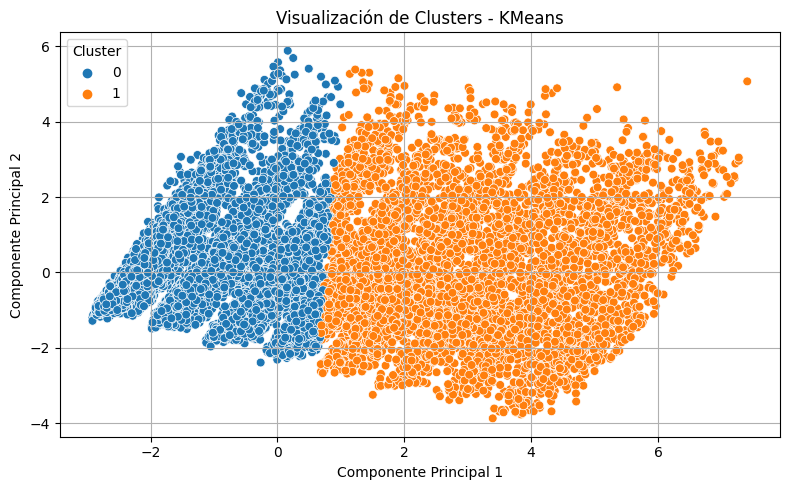

In [6]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Modelo final con mejores hiperparámetros 
modelo_kmeans_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('segmentador', KMeans(n_clusters=2, init='k-means++', max_iter=300, random_state=42))  
])

# Entrenar el modelo
modelo_kmeans_final.fit(X_sample)

# Obtener etiquetas del modelo
etiquetas_kmeans = modelo_kmeans_final.named_steps['segmentador'].labels_

# Evaluación interna del modelo
X_proc = preprocessor.transform(X_sample)  # Asegúrate de transformar los datos
print("📈 Evaluación interna del modelo KMeans:")
print("Silhouette Score:", silhouette_score(X_proc, etiquetas_kmeans))
print("Davies-Bouldin Score:", davies_bouldin_score(X_proc, etiquetas_kmeans))
print("Calinski-Harabasz Score:", calinski_harabasz_score(X_proc, etiquetas_kmeans))

# Evaluación externa del clustering
print("\n📊 Evaluación externa con respecto a 'Diabetes_binary':")
print("ARI (Adjusted Rand Index):", adjusted_rand_score(y_sample, etiquetas_kmeans))
print("NMI (Normalized Mutual Information):", normalized_mutual_info_score(y_sample, etiquetas_kmeans))
print("Homogeneity:", homogeneity_score(y_sample, etiquetas_kmeans))
print("Completeness:", completeness_score(y_sample, etiquetas_kmeans))
print("V-Measure:", v_measure_score(y_sample, etiquetas_kmeans))

# Visualización con PCA
X_reducido = PCA(n_components=2).fit_transform(X_proc)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_reducido[:, 0], y=X_reducido[:, 1], hue=etiquetas_kmeans, palette='tab10', s=40)
plt.title("Visualización de Clusters - KMeans")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Guardar resultados 
resultados_kmeans_final = {
    "Modelo": "KMeans",
    "Silhouette Score": round(silhouette_score(X_proc, etiquetas_kmeans), 4),
    "Davies-Bouldin Score": round(davies_bouldin_score(X_proc, etiquetas_kmeans), 4),
    "Calinski-Harabasz Score": round(calinski_harabasz_score(X_proc, etiquetas_kmeans), 4),
    "ARI": round(adjusted_rand_score(y_sample, etiquetas_kmeans), 4),
    "NMI": round(normalized_mutual_info_score(y_sample, etiquetas_kmeans), 4),
    "Homogeneity": round(homogeneity_score(y_sample, etiquetas_kmeans), 4),
    "Completeness": round(completeness_score(y_sample, etiquetas_kmeans), 4),
    "V-Measure": round(v_measure_score(y_sample, etiquetas_kmeans), 4)
}

# Agregar a la lista de resultados
resultados_completos = []
resultados_completos.append(resultados_kmeans_final)

## DBSCAN

📈 Evaluación interna del modelo DBSCAN:
Silhouette Score: -0.39537529614884925
Davies-Bouldin Score: 1.7372517709866002
Calinski-Harabasz Score: 39.1193115883362

📊 Evaluación externa con respecto a 'Diabetes_binary':
ARI (Adjusted Rand Index): -0.062092881388332126
NMI (Normalized Mutual Information): 0.03173075847203673
Homogeneity: 0.04669718072912807
Completeness: 0.024029360778223575
V-Measure: 0.031730758472036734


/var/folders/kr/tthmj85s4dd4sr5llsm1vvlh0000gn/T/ipykernel_85194/1946062645.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


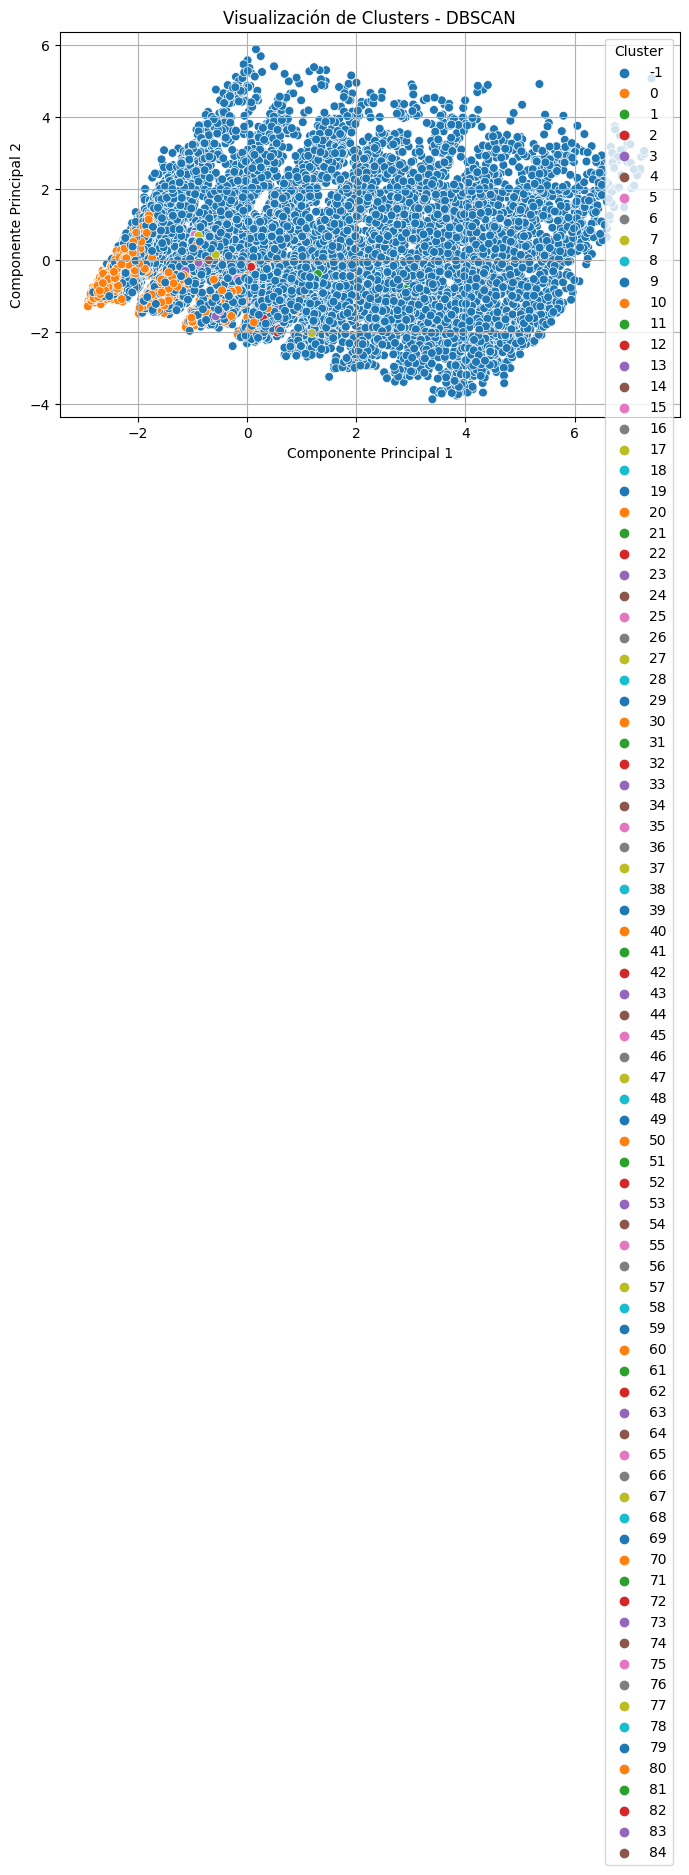

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Definir modelo DBSCAN s
modelo_dbscan_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('segmentador', DBSCAN(eps=1.0, min_samples=5))  
])

# Entrenar el modelo
modelo_dbscan_final.fit(X_sample)

# Obtener etiquetas
etiquetas_dbscan = modelo_dbscan_final.named_steps['segmentador'].labels_

# Datos transformados para métricas
X_proc = preprocessor.transform(X_sample)

# Métricas internas (solo si hay más de un cluster)
if len(set(etiquetas_dbscan)) > 1 and -1 in etiquetas_dbscan:
    print("📈 Evaluación interna del modelo DBSCAN:")
    print("Silhouette Score:", silhouette_score(X_proc, etiquetas_dbscan))
    print("Davies-Bouldin Score:", davies_bouldin_score(X_proc, etiquetas_dbscan))
    print("Calinski-Harabasz Score:", calinski_harabasz_score(X_proc, etiquetas_dbscan))
else:
    print("No se pueden calcular métricas internas: solo hay un cluster o todos los puntos son ruido.")

# Métricas externas
print("\n📊 Evaluación externa con respecto a 'Diabetes_binary':")
print("ARI (Adjusted Rand Index):", adjusted_rand_score(y_sample, etiquetas_dbscan))
print("NMI (Normalized Mutual Information):", normalized_mutual_info_score(y_sample, etiquetas_dbscan))
print("Homogeneity:", homogeneity_score(y_sample, etiquetas_dbscan))
print("Completeness:", completeness_score(y_sample, etiquetas_dbscan))
print("V-Measure:", v_measure_score(y_sample, etiquetas_dbscan))

# Visualización con PCA
X_reducido = PCA(n_components=2).fit_transform(X_proc)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_reducido[:, 0], y=X_reducido[:, 1], hue=etiquetas_dbscan, palette='tab10', s=40)
plt.title("Visualización de Clusters - DBSCAN")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Crear diccionario con métricas de evaluación
resultados_dbscan_final = {
    "Modelo": "DBSCAN",
    "Silhouette Score": round(silhouette_score(X_proc, etiquetas_dbscan), 4) if len(set(etiquetas_dbscan)) > 1 and -1 in etiquetas_dbscan else "NA",
    "Davies-Bouldin Score": round(davies_bouldin_score(X_proc, etiquetas_dbscan), 4) if len(set(etiquetas_dbscan)) > 1 and -1 in etiquetas_dbscan else "NA",
    "Calinski-Harabasz Score": round(calinski_harabasz_score(X_proc, etiquetas_dbscan), 4) if len(set(etiquetas_dbscan)) > 1 and -1 in etiquetas_dbscan else "NA",
    "ARI": round(adjusted_rand_score(y_sample, etiquetas_dbscan), 4),
    "NMI": round(normalized_mutual_info_score(y_sample, etiquetas_dbscan), 4),
    "Homogeneity": round(homogeneity_score(y_sample, etiquetas_dbscan), 4),
    "Completeness": round(completeness_score(y_sample, etiquetas_dbscan), 4),
    "V-Measure": round(v_measure_score(y_sample, etiquetas_dbscan), 4)
}

# Agregar a la lista de resultados
resultados_completos.append(resultados_dbscan_final)

## BIRCH

📈 Evaluación interna del modelo BIRCH:
Silhouette Score: 0.2879697882587598
Davies-Bouldin Score: 1.527201658657944
Calinski-Harabasz Score: 8513.712569060199

📊 Evaluación externa con respecto a 'Diabetes_binary':
ARI (Adjusted Rand Index): 0.06805216361316602
NMI (Normalized Mutual Information): 0.02174462500583751
Homogeneity: 0.027754439336001514
Completeness: 0.017874225255373667
V-Measure: 0.021744625005837504


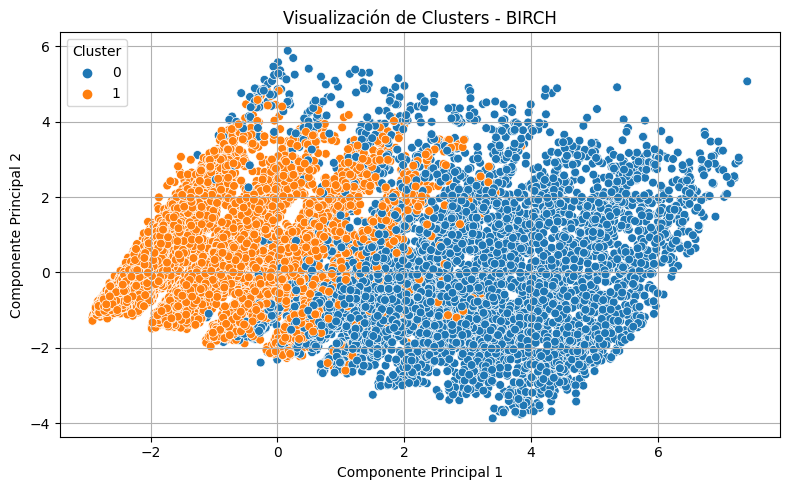

In [8]:
from sklearn.cluster import Birch
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Definir modelo BIRCH con mejores parámetros encontrados
modelo_birch_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('segmentador', Birch(n_clusters=2, threshold=0.5)) 
])

# Entrenar el modelo
modelo_birch_final.fit(X_sample)

# Obtener etiquetas
etiquetas_birch = modelo_birch_final.named_steps['segmentador'].labels_

# Datos preprocesados
X_proc = preprocessor.transform(X_sample)

# Evaluación interna del modelo (si hay más de un cluster)
if len(set(etiquetas_birch)) > 1:
    print("📈 Evaluación interna del modelo BIRCH:")
    print("Silhouette Score:", silhouette_score(X_proc, etiquetas_birch))
    print("Davies-Bouldin Score:", davies_bouldin_score(X_proc, etiquetas_birch))
    print("Calinski-Harabasz Score:", calinski_harabasz_score(X_proc, etiquetas_birch))
else:
    print("No se pueden calcular métricas internas: solo hay un cluster.")

# Evaluación externa con respecto a la clase conocida
print("\n📊 Evaluación externa con respecto a 'Diabetes_binary':")
print("ARI (Adjusted Rand Index):", adjusted_rand_score(y_sample, etiquetas_birch))
print("NMI (Normalized Mutual Information):", normalized_mutual_info_score(y_sample, etiquetas_birch))
print("Homogeneity:", homogeneity_score(y_sample, etiquetas_birch))
print("Completeness:", completeness_score(y_sample, etiquetas_birch))
print("V-Measure:", v_measure_score(y_sample, etiquetas_birch))

# Visualización de clusters con PCA
X_reducido = PCA(n_components=2).fit_transform(X_proc)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_reducido[:, 0], y=X_reducido[:, 1], hue=etiquetas_birch, palette='tab10', s=40)
plt.title("Visualización de Clusters - BIRCH")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Crear diccionario con métricas de evaluación para BIRCH
resultados_birch_final = {
    "Modelo": "BIRCH",
    "Silhouette Score": round(silhouette_score(X_proc, etiquetas_birch), 4) if len(set(etiquetas_birch)) > 1 else "NA",
    "Davies-Bouldin Score": round(davies_bouldin_score(X_proc, etiquetas_birch), 4) if len(set(etiquetas_birch)) > 1 else "NA",
    "Calinski-Harabasz Score": round(calinski_harabasz_score(X_proc, etiquetas_birch), 4) if len(set(etiquetas_birch)) > 1 else "NA",
    "ARI": round(adjusted_rand_score(y_sample, etiquetas_birch), 4),
    "NMI": round(normalized_mutual_info_score(y_sample, etiquetas_birch), 4),
    "Homogeneity": round(homogeneity_score(y_sample, etiquetas_birch), 4),
    "Completeness": round(completeness_score(y_sample, etiquetas_birch), 4),
    "V-Measure": round(v_measure_score(y_sample, etiquetas_birch), 4)
}

# Agregar a la lista de resultados
resultados_completos.append(resultados_birch_final)

## Agglomerative Clustering

📈 Evaluación interna del modelo Agglomerative:
Silhouette Score: 0.3124561006728495
Davies-Bouldin Score: 1.4064282182570285
Calinski-Harabasz Score: 7680.648047299201

📊 Evaluación externa con respecto a 'Diabetes_binary':
ARI (Adjusted Rand Index): 0.11523072839099739
NMI (Normalized Mutual Information): 0.030508947825001353
Homogeneity: 0.03462245359431716
Completeness: 0.02726909692274845
V-Measure: 0.03050894782500135


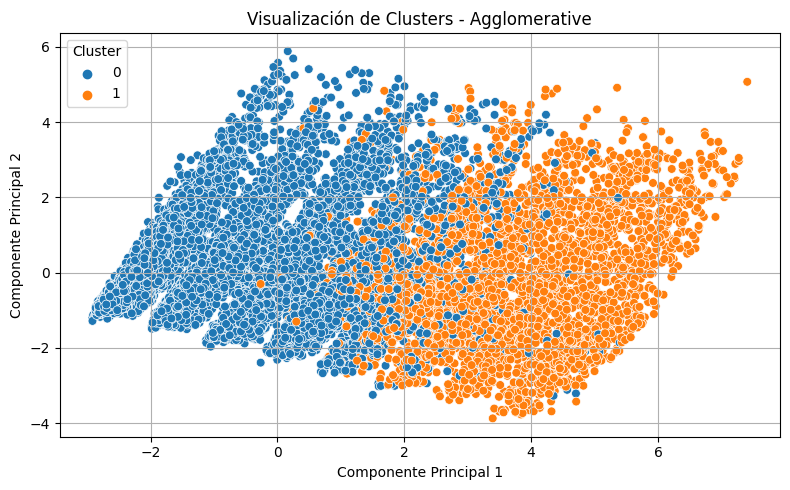

In [9]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
import matplotlib.pyplot as plt
import seaborn as sns

# Crear pipeline con preprocesamiento y modelo
modelo_agglom_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('segmentador', AgglomerativeClustering(n_clusters=2))  
])

# Entrenar el modelo
modelo_agglom_final.fit(X_sample)

# Obtener etiquetas del modelo
etiquetas_agglom = modelo_agglom_final.named_steps['segmentador'].labels_

# Transformar X para métricas internas
X_proc = preprocessor.transform(X_sample)

# Evaluación interna
if len(set(etiquetas_agglom)) > 1:
    print("📈 Evaluación interna del modelo Agglomerative:")
    print("Silhouette Score:", silhouette_score(X_proc, etiquetas_agglom))
    print("Davies-Bouldin Score:", davies_bouldin_score(X_proc, etiquetas_agglom))
    print("Calinski-Harabasz Score:", calinski_harabasz_score(X_proc, etiquetas_agglom))
else:
    print("Solo se generó un cluster. No se pueden calcular métricas internas.")

# Evaluación externa con respecto a la clase conocida
print("\n📊 Evaluación externa con respecto a 'Diabetes_binary':")
print("ARI (Adjusted Rand Index):", adjusted_rand_score(y_sample, etiquetas_agglom))
print("NMI (Normalized Mutual Information):", normalized_mutual_info_score(y_sample, etiquetas_agglom))
print("Homogeneity:", homogeneity_score(y_sample, etiquetas_agglom))
print("Completeness:", completeness_score(y_sample, etiquetas_agglom))
print("V-Measure:", v_measure_score(y_sample, etiquetas_agglom))

# Visualización PCA
X_reducido = PCA(n_components=2).fit_transform(X_proc)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_reducido[:, 0], y=X_reducido[:, 1], hue=etiquetas_agglom, palette='tab10', s=40)
plt.title("Visualización de Clusters - Agglomerative")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Crear diccionario con métricas de evaluación
resultados_agglom_final = {
    "Modelo": "Agglomerative",
    "Silhouette Score": round(silhouette_score(X_proc, etiquetas_agglom), 4) if len(set(etiquetas_agglom)) > 1 else "NA",
    "Davies-Bouldin Score": round(davies_bouldin_score(X_proc, etiquetas_agglom), 4) if len(set(etiquetas_agglom)) > 1 else "NA",
    "Calinski-Harabasz Score": round(calinski_harabasz_score(X_proc, etiquetas_agglom), 4) if len(set(etiquetas_agglom)) > 1 else "NA",
    "ARI": round(adjusted_rand_score(y_sample, etiquetas_agglom), 4),
    "NMI": round(normalized_mutual_info_score(y_sample, etiquetas_agglom), 4),
    "Homogeneity": round(homogeneity_score(y_sample, etiquetas_agglom), 4),
    "Completeness": round(completeness_score(y_sample, etiquetas_agglom), 4),
    "V-Measure": round(v_measure_score(y_sample, etiquetas_agglom), 4)
}

# Agregar a la lista de resultados
resultados_completos.append(resultados_agglom_final)

## Resultados

In [10]:
df_resultados_segmentacion = pd.DataFrame(resultados_completos)
display(df_resultados_segmentacion)

,Modelo,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score,ARI,NMI,Homogeneity,Completeness,V-Measure
0,KMeans,0.3128,1.4275,9910.7460,0.0829,0.0314,0.0403,0.0258,0.0314
1,DBSCAN,-0.3954,1.7373,39.1193,-0.0621,0.0317,0.0467,0.0240,0.0317
2,BIRCH,0.2880,1.5272,8513.7126,0.0681,0.0217,0.0278,0.0179,0.0217
3,Agglomerative,0.3125,1.4064,7680.6480,0.1152,0.0305,0.0346,0.0273,0.0305


## Conclusiones

KMeans logra el mejor desempeño interno global (mayor silhouette y Calinski-Harabasz).

Agglomerative presenta el mejor ARI (0.1152), por tanto mejor alineado con las clases reales aunque de manera limitada.

DBSCAN fracasa en todos los aspectos: Silhouette negativo, bajo CH Score y ARI negativo. Puede que eps/min_samples no estén bien ajustados para estos datos.

BIRCH tiene resultados intermedios pero por debajo de KMeans y Agglomerative.

KMeans y Agglomerative Clustering son los modelos más sólidos. 